<a href="https://colab.research.google.com/github/Faissen/Hypothesis-and-A-B-testing/blob/main/Hypothesis_testing_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the data

In [22]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy import stats as st

In [23]:
#Import the data
hypothesis = pd.read_csv('hypotheses_us.csv', sep=';')
print(hypothesis.head(), '\n')

# Check the data
print(hypothesis.info(), '\n')
print(hypothesis.describe(), '\n')
print(f'Duplicated lines: ', hypothesis.duplicated().sum(), '\n')
print(f'Null-values by columns: ', '\n', hypothesis.isnull().sum())


                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0

No null values, nor duplicated lines. Data types are correct.

In [24]:
# Snake_case
new_columns_name = []
for column_name in hypothesis.columns:
    name_lowered = column_name.lower()
    new_columns_name.append(name_lowered)

hypothesis.columns = new_columns_name
print(hypothesis.head())

                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   confidence  effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  


# Part 1 - Prioritizing hypothesis

## 1 - Classification following framework ICE

In [25]:
# ICE = Impact x Confidence x Ease
# ICE score = (Impact x Confidence) / Ease

hypothesis['ice'] = round(((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['effort']),1)
hypothesis = hypothesis.sort_values(by='ice', ascending=False)
hypothesis_ice = hypothesis[['hypothesis','ice']]
print(hypothesis_ice)

                                          hypothesis   ice
8  Launch a promotion that gives users discounts ...  16.2
0  Add two new channels for attracting traffic. T...  13.3
7  Add a subscription form to all the main pages....  11.2
6  Show banners with current offers and sales on ...   8.0
2  Add product recommendation blocks to the store...   7.0
1  Launch your own delivery service. This will sh...   2.0
5  Add a customer review page. This will increase...   1.3
3  Change the category structure. This will incre...   1.1
4  Change the background color on the main page. ...   1.0


## 2 - Classification following framework RICE

In [26]:
# RICE = Reach x Impact x Confidence x Ease
# ICE score = (Reach x Impact x Confidence) / Ease

hypothesis['rice'] = round(((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['effort']),1)
hypothesis = hypothesis.sort_values(by='rice', ascending=False)
hypothesis_rice = hypothesis[['hypothesis','rice']]
print(hypothesis_rice)

                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


## 3 - How does the classification change between ICE and RICE? Why does it happen?

The main difference between ICE and RICE is that RICE considers how many users will be impacted by the change.

The main hypohesis from ICE are hypothesis 8, 0, 7 and 6.

The main hypohesis from RICE are hypothesis 7, 2, 0 and 6.

Hypothesis 0 and 7 appears in both analysis in the first four places.

In [27]:
print(f'Hypothesis 0: ', hypothesis['hypothesis'][0], '\n',f'Hypothesis 7: ', hypothesis['hypothesis'][7])

Hypothesis 0:  Add two new channels for attracting traffic. This will bring 30% more users 
 Hypothesis 7:  Add a subscription form to all the main pages. This will help you compile a mailing list


# Part 2 - A/B testing

In [28]:
#Import the data (optimized option)
orders = pd.read_csv('orders_us.csv', sep=',', dtype={'group':'category'} , parse_dates=['date'])
print(orders.head(), '\n')

# Check the data
print(orders.info(), '\n')
print(orders.describe(), '\n')
print(f'Duplicated lines: ', orders.duplicated().sum(), '\n')
print(f'Null-values by columns: ', '\n', orders.isnull().sum())

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
2     2961555356  4069496402 2019-08-15     10.2     A
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB
None 

       transactionId     visitorId                           date  \
count   1.197000e+03  1.197000e+03            

No null values, nor duplicated lines. Data types are correct fter loading group and date with the most adequate data types.

In [29]:
# Snake_case
def snake_columns(df):
    df.columns = [
        re.sub(r'(?<!_)Id$', '_id', col)  # adds _ prior to 'Id' at the end
           .replace('Id', '_id')
           .lower()
        for col in df.columns
    ]
    return df

snake_columns(orders)
print(orders.head())

   transaction_id  visitor_id       date  revenue group
0      3667963787  3312258926 2019-08-15     30.4     B
1      2804400009  3642806036 2019-08-15     15.2     B
2      2961555356  4069496402 2019-08-15     10.2     A
3      3797467345  1196621759 2019-08-15    155.1     B
4      2282983706  2322279887 2019-08-15     40.5     B


In [30]:
#Import the data (optimized option)
visits = pd.read_csv('visits_us.csv', sep=',', dtype={'group':'category'} , parse_dates=['date'])
print(visits.head(), '\n')

# Check the data
print(visits.info(), '\n')
print(visits.describe(), '\n')
print(f'Duplicated lines: ', visits.duplicated().sum(), '\n')
print(f'Null-values by columns: ', '\n', visits.isnull().sum())

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.2 KB
None 

                      date      visits
count                   62   62.000000
mean   2019-08-16 00:00:00  607.290323
min    2019-08-01 00:00:00  361.000000
25%    2019-08-08 06:00:00  534.000000
50%    2019-08-16 00:00:00  624.500000
75%    2019-08-23 18:00:00  710.500000
max    2019-08-31 00:00:00  770.000000
std                    NaN  114.400560 

Duplicated lines:  0 

Null-values by columns:  
 date      0
group     0
visits    

No null values, nor duplicated lines. Data types are correct fter loading group and date with the most adequate data types.

## 1- Plot cumulated revenue by group. Take conclusions and build conjectures.

/tmp/ipykernel_13466/10227920.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_group = orders.groupby('group')['revenue'].sum().reset_index()


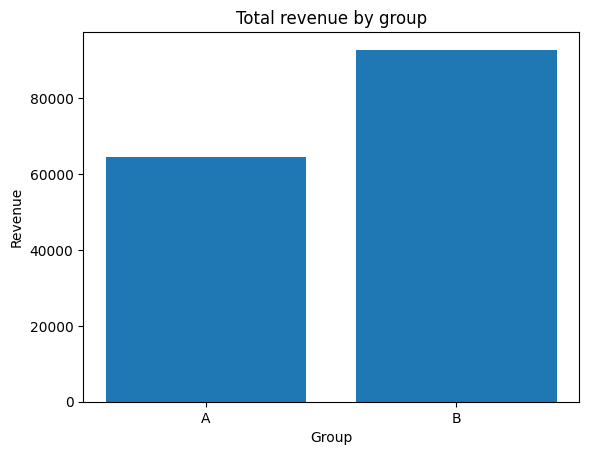

Revenue of group B is 1.4x bigger than revenue of group A.


In [31]:
revenue_by_group = orders.groupby('group')['revenue'].sum().reset_index()
#print(revenue_by_group)

plt.bar(revenue_by_group['group'], revenue_by_group['revenue'])
plt.title('Total revenue by group')
plt.xlabel('Group')
plt.ylabel('Revenue')
plt.show()

revenue_rate = round(revenue_by_group[revenue_by_group['group']=='B']['revenue'].values[0] /
                     revenue_by_group[revenue_by_group['group']=='A']['revenue'].values[0] ,1)

print(f'Revenue of group B is {revenue_rate}x bigger than revenue of group A.')

Why is group B total revenue bigger than group A? Do both groups have the same size and the same time period?

## 2- Plot average cumulated revenue by group. Take conclusions and build conjectures.

        date group  avg_revenue
0 2019-08-01     A    98.200000
1 2019-08-01     B    77.142857
2 2019-08-02     A    75.175000
3 2019-08-02     B   109.325000
4 2019-08-03     A    75.633333


/tmp/ipykernel_13466/4293181324.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_group_and_date = orders.groupby(['date','group'])['revenue'].mean().reset_index()


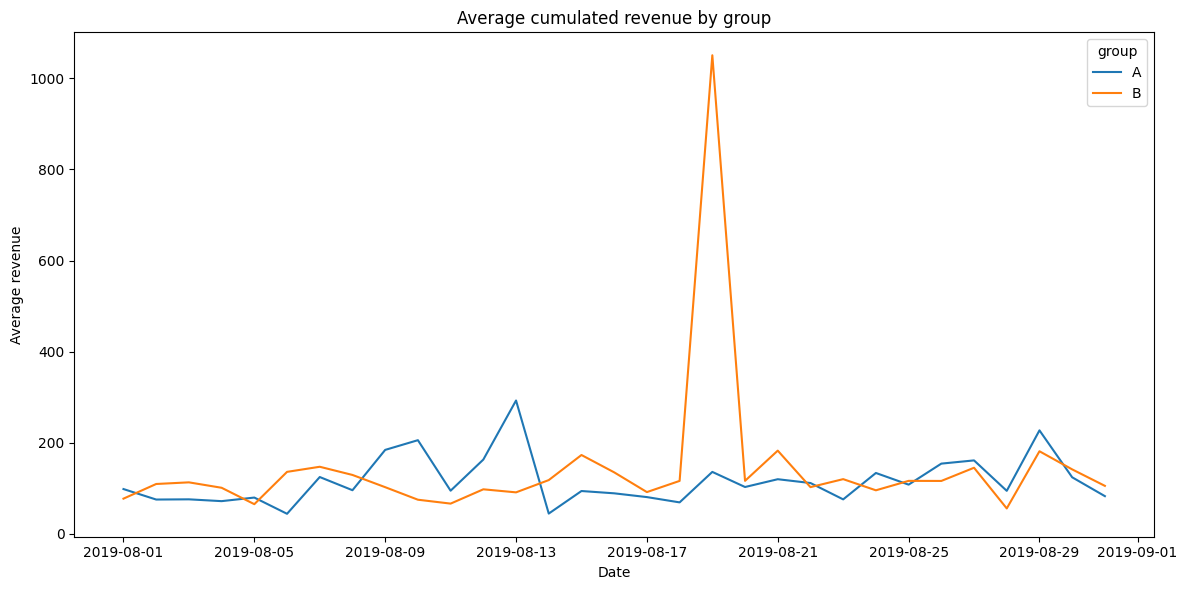

In [32]:
revenue_by_group_and_date = orders.groupby(['date','group'])['revenue'].mean().reset_index()
revenue_by_group_and_date.rename(columns={'revenue':'avg_revenue'}, inplace=True)
print(revenue_by_group_and_date.head())

plt.figure(figsize=(12, 6))
sns.lineplot(data=revenue_by_group_and_date, x='date',y='avg_revenue', hue='group')
plt.title('Average cumulated revenue by group')
plt.xlabel('Date')
plt.ylabel('Average revenue')
plt.tight_layout()
plt.show()

There are some atypical vales in both groups B, more visible in group B.

## 3- Plot the relative difference of the average cumulated revenue of group B regarding group A.  Take conclusions and build conjectures.

        date  avg_revenueA  avg_revenueB
0 2019-08-01     98.200000     77.142857
1 2019-08-02     75.175000    109.325000
2 2019-08-03     75.633333    112.925000
3 2019-08-04     71.662500    101.017647
4 2019-08-05     79.524000     65.000000 



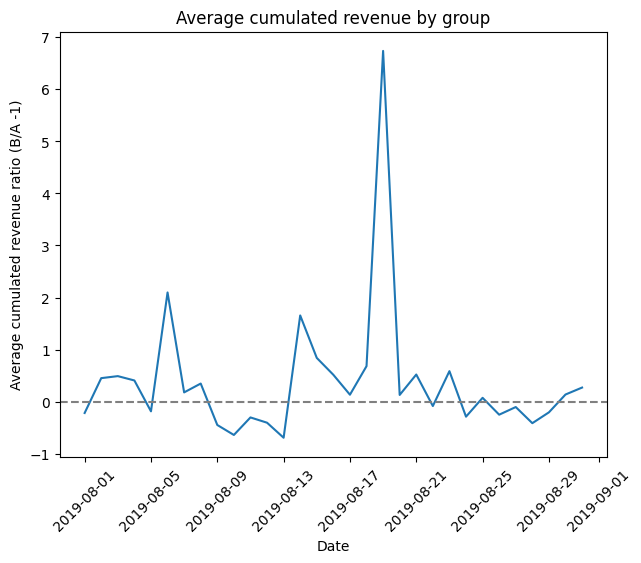

In [33]:
cumulative_revenueA = revenue_by_group_and_date[revenue_by_group_and_date['group']=='A'].rename(columns={'avg_revenue':'avg_revenueA'}).drop(columns='group')
cumulative_revenueB = revenue_by_group_and_date[revenue_by_group_and_date['group']=='B'].rename(columns={'avg_revenue':'avg_revenueB'}).drop(columns='group')
cumulative_revenue_merged = cumulative_revenueA.merge(cumulative_revenueB, on='date', how='left')
#print(cumulative_revenueA.head(), '\n')
#print(cumulative_revenueB.head(), '\n')
print(cumulative_revenue_merged.head(), '\n')

plt.plot(cumulative_revenue_merged['date'],(cumulative_revenue_merged['avg_revenueB'] / cumulative_revenue_merged['avg_revenueA'])-1)
plt.axhline(y=0, color='grey',linestyle='--')
plt.tight_layout()
plt.xticks(rotation=45)
plt.title('Average cumulated revenue by group')
plt.xlabel('Date')
plt.ylabel('Average cumulated revenue ratio (B/A -1)');

Trends with some variability and inconsistencies. May be related to atypical values detected previouslly. Nevetheless, from 28.August group A average revenue started increasing compared with group B.

## 4- Calculate the conversion rate of each group as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and formulate hypotheses.

        date  transaction_id
0 2019-08-01              45
1 2019-08-02              44
2 2019-08-03              40
3 2019-08-04              33
4 2019-08-05              48 

        date group  visits
0 2019-08-01     A     719
1 2019-08-01     B     713
2 2019-08-02     A     619
3 2019-08-02     B     581
4 2019-08-03     A     507 

        date group  visits  transaction_id  conversion_rate
0 2019-08-01     A     719              45             6.26
1 2019-08-01     B     713              45             6.31
2 2019-08-02     A     619              44             7.11
3 2019-08-02     B     581              44             7.57
4 2019-08-03     A     507              40             7.89 



/tmp/ipykernel_13466/1630368271.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_visits_by_group = visits.groupby(['date','group'])['visits'].sum().reset_index()


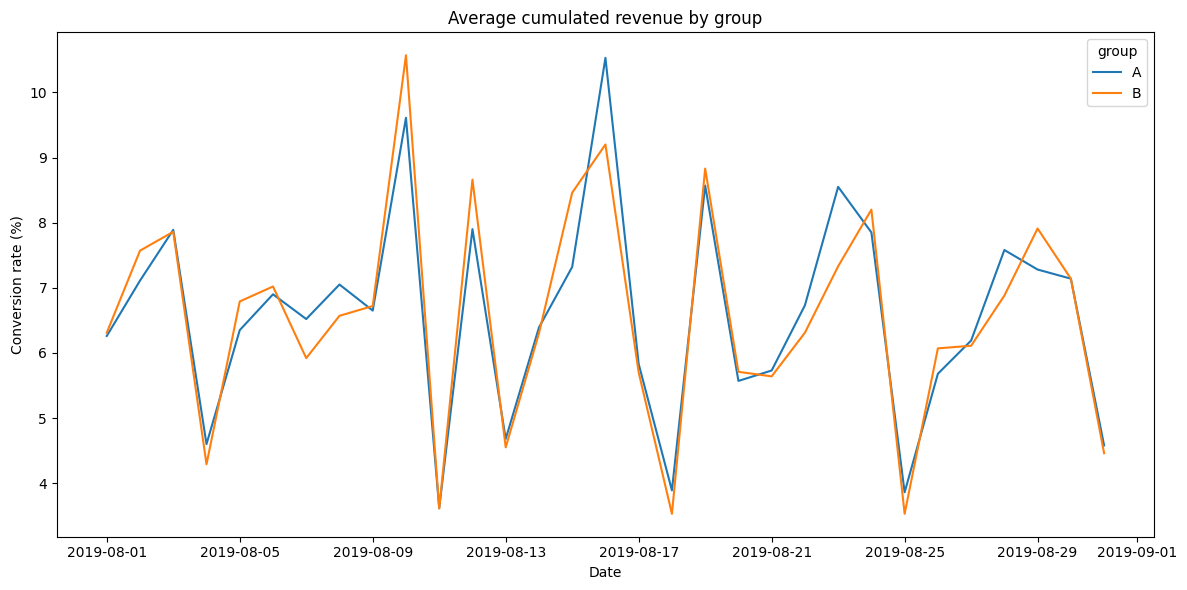

In [34]:
# Conversion rate = daily_orders / daily_visits
daily_orders = orders.groupby('date')['transaction_id'].nunique().reset_index()
print(daily_orders.head(),'\n')

daily_visits_by_group = visits.groupby(['date','group'])['visits'].sum().reset_index()
print(daily_visits_by_group.head(),'\n')

daily_visits_by_group_merged = daily_visits_by_group.merge(daily_orders,on='date',how='left')
#print(daily_visits_by_group_merged.head(),'\n')

daily_visits_by_group_merged['conversion_rate'] = round(daily_visits_by_group_merged['transaction_id'] / daily_visits_by_group_merged['visits'] *100,2)
print(daily_visits_by_group_merged.head(),'\n')

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_visits_by_group_merged, x='date',y='conversion_rate', hue='group')
plt.title('Average cumulated revenue by group')
plt.xlabel('Date')
plt.ylabel('Conversion rate (%)')
plt.tight_layout()
plt.show()

Conversion rate for both groups is very instable.

## 5- Plot the relative difference in cumulative conversion for group B compared to group A. Draw conclusions and formulate hypotheses.

        date  conversion_rateA  conversion_rateB
0 2019-08-01              6.26              6.31
1 2019-08-02              7.11              7.57
2 2019-08-03              7.89              7.86
3 2019-08-04              4.60              4.29
4 2019-08-05              6.35              6.79 



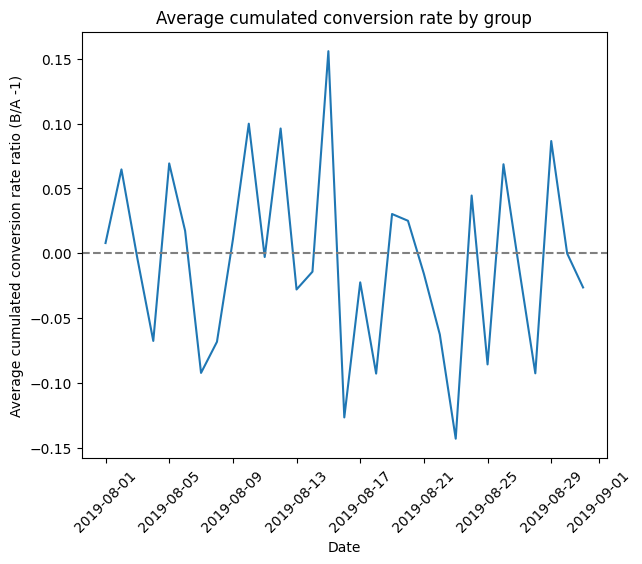

In [35]:
cumulative_conversionA = daily_visits_by_group_merged[daily_visits_by_group_merged['group']=='A'].rename(
    columns={'conversion_rate':'conversion_rateA'}).drop(columns=['group','visits','transaction_id'])
cumulative_conversionB = daily_visits_by_group_merged[daily_visits_by_group_merged['group']=='B'].rename(
    columns={'conversion_rate':'conversion_rateB'}).drop(columns=['group','visits','transaction_id'])
cumulative_conversion_merged = cumulative_conversionA.merge(cumulative_conversionB, on='date', how='left')
#print(cumulative_conversionA.head(), '\n')
#print(cumulative_conversionB.head(), '\n')
print(cumulative_conversion_merged.head(), '\n')


plt.plot(cumulative_conversion_merged['date'],
         (cumulative_conversion_merged['conversion_rateB'] / cumulative_conversion_merged['conversion_rateA'])
         -1)
plt.axhline(y=0, color='grey',linestyle='--')
plt.tight_layout()
plt.xticks(rotation=45)
plt.title('Average cumulated conversion rate by group')
plt.xlabel('Date')
plt.ylabel('Average cumulated conversion rate ratio (B/A -1)');

Trends with some variability. Group B started better,than conversion rate started being below group A. Crrently conversion rate of group B is improving.

## 6- Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [36]:
#Number of orders by user
orders_by_users = orders.groupby('visitor_id')['transaction_id'].nunique().reset_index().sort_values(by='transaction_id', ascending=True)
print(orders_by_users.head(),'\n')

percentiles = np.percentile(orders_by_users['transaction_id'],[95,99])
print(f'95% of users made {percentiles[0]} orders or less')
print(f'99% of users made {percentiles[1]} orders or less', '\n')

     visitor_id  transaction_id
678  2785040378               1
656  2705308997               1
658  2710193528               1
659  2710478747               1
660  2710492161               1 

95% of users made 2.0 orders or less
99% of users made 4.0 orders or less 



More than 2 orders per user may be considered an anomaly.

## 7- Create a scatter plot of the order prices. Draw conclusions and formulate hypotheses.

   transaction_id  revenue
0         1062393    100.8
1         4919758     40.2
2         7210578     60.5
3         8131427     75.5
4        11068804     75.7 



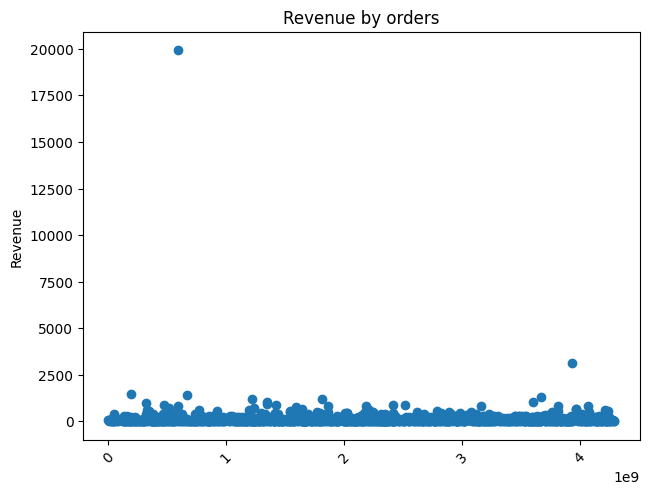

In [37]:
#Number of orders by user
revenue_by_orders = orders.groupby('transaction_id')['revenue'].sum().reset_index()
print(revenue_by_orders.head(),'\n')

x_values = pd.Series(range(0,len(revenue_by_orders['revenue'])))
plt.scatter(revenue_by_orders['transaction_id'],revenue_by_orders['revenue'])
plt.tight_layout()
plt.xticks(rotation=45)
plt.title('Revenue by orders')
plt.ylabel('Revenue');

There are some atypical results that should be disregarded to obtain a more valid analysis.

## 8- Calculate the 95th and 99th percentiles of the order prices. Define the point at which a data point becomes an anomaly.

In [38]:
percentiles2 = np.percentile(revenue_by_orders['revenue'],[95,99])
print(f'95% of orders is <= {percentiles2[0]}')
print(f'99% of orders is <= {percentiles2[1]}', '\n')

95% of orders is <= 435.54
99% of orders is <= 900.9039999999999 



## 9- Find the statistical significance of the difference in conversion between the groups using the raw data. Draw conclusions and formulate hypotheses.

In [39]:
print(cumulative_conversion_merged.head(), '\n')
# Print p-value
p_value = round(st.mannwhitneyu(cumulative_conversion_merged['conversion_rateA'], cumulative_conversion_merged['conversion_rateB'])[1],3)
print(f'p-value is {p_value}')

conversion_gain = cumulative_conversion_merged['conversion_rateB'].mean() / cumulative_conversion_merged['conversion_rateA'].mean() -1
print(f'Conversion gain from group B to group A is {round(conversion_gain*100,1)}%')

        date  conversion_rateA  conversion_rateB
0 2019-08-01              6.26              6.31
1 2019-08-02              7.11              7.57
2 2019-08-03              7.89              7.86
3 2019-08-04              4.60              4.29
4 2019-08-05              6.35              6.79 

p-value is 0.905
Conversion gain from group B to group A is -0.3%


p-value is > 0.05 therefore we can not reject the null hypothesis. There is no statiscal significance regarding conversion between groups A and B.

## 10- Find the statistical significance of the difference in average order size between the groups using the raw data. Draw conclusions and formulate hypotheses.

In [40]:
print(cumulative_revenue_merged.head(), '\n')
# Print p-value
p_value = round(st.mannwhitneyu(cumulative_revenue_merged['avg_revenueA'], cumulative_revenue_merged['avg_revenueB'])[1],2)
print(f'p-value is {p_value}')

revenue_gain = cumulative_revenue_merged['avg_revenueB'].mean() / cumulative_revenue_merged['avg_revenueA'].mean() -1
print(f'Revenue gain from group B to group A is {round(revenue_gain*100,1)}%')

        date  avg_revenueA  avg_revenueB
0 2019-08-01     98.200000     77.142857
1 2019-08-02     75.175000    109.325000
2 2019-08-03     75.633333    112.925000
3 2019-08-04     71.662500    101.017647
4 2019-08-05     79.524000     65.000000 

p-value is 0.42
Revenue gain from group B to group A is 23.8%


p-value is > 0.05 therefore we can not reject the null hypothesis. There is no statiscal significance in revenue change between groups A and B even though the difference is~24%.

## 11- Find the statistical significance of the difference in conversion between the groups using the filtered data. Draw conclusions and formulate hypotheses.

In [41]:
# Filter data

#95 and 99º percentile:
# Orders: 2, 4
# Revenue: 435.54, 900.90

orders_visits = orders.merge(visits,on=['date','group'], how='left')
#print(orders_visits.head())
#print(orders_visits.info())
orders_visits_filtered = orders_visits[
    (orders_visits['revenue'] <= 500) &
    (orders_visits.groupby('visitor_id')['transaction_id'].transform('count') < 4)
]

print(orders_visits_filtered.head())
#print(orders_visits_filtered.info())

# Conversion rate = daily_orders / daily_visits
daily_orders_filtered = orders_visits_filtered.groupby('date')['transaction_id'].nunique().reset_index()
print(daily_orders_filtered.head())

daily_visits_by_group_filtered = orders_visits_filtered.groupby(['date','group'])['visits'].sum().reset_index()
print(daily_visits_by_group_filtered.head(),'\n')

daily_visits_by_group_filtered_merged = daily_visits_by_group_filtered.merge(daily_orders_filtered,on='date',how='left')
print(daily_visits_by_group_filtered_merged.head(),'\n')

daily_visits_by_group_filtered_merged['conversion_rate'] = round(daily_visits_by_group_filtered_merged['transaction_id'] /
                                                                 daily_visits_by_group_filtered_merged ['visits'] *100,2)
print(daily_visits_by_group_filtered_merged.head(),'\n')


cumulative_conversionA_filtered = daily_visits_by_group_filtered_merged[daily_visits_by_group_filtered_merged['group']=='A'].rename(
    columns={'conversion_rate':'conversion_rateA'}).drop(columns=['group','visits','transaction_id'])
cumulative_conversionB_filtered = daily_visits_by_group_filtered_merged[daily_visits_by_group_filtered_merged['group']=='B'].rename(
    columns={'conversion_rate':'conversion_rateB'}).drop(columns=['group','visits','transaction_id'])
cumulative_conversion_merged_filtered = cumulative_conversionA_filtered.merge(cumulative_conversionB_filtered, on='date', how='left')
#print(cumulative_conversionA.head(), '\n')
#print(cumulative_conversionB.head(), '\n')
print(cumulative_conversion_merged_filtered.head(), '\n')

# Print p-value
p_value_filtered = round(st.mannwhitneyu(cumulative_conversion_merged_filtered['conversion_rateA'],
                                cumulative_conversion_merged_filtered['conversion_rateB'])[1],3)
print(f'p-value is {p_value_filtered}')

conversion_gain_filtered = (cumulative_conversion_merged_filtered['conversion_rateB'].mean() /
                   cumulative_conversion_merged_filtered['conversion_rateA'].mean()) -1
print(f'Conversion gain from group B to group A is {round(conversion_gain_filtered*100,1)}%')

   transaction_id  visitor_id       date  revenue group  visits
0      3667963787  3312258926 2019-08-15     30.4     B     544
1      2804400009  3642806036 2019-08-15     15.2     B     544
2      2961555356  4069496402 2019-08-15     10.2     A     628
3      3797467345  1196621759 2019-08-15    155.1     B     544
4      2282983706  2322279887 2019-08-15     40.5     B     544
        date  transaction_id
0 2019-08-01              42
1 2019-08-02              42
2 2019-08-03              40
3 2019-08-04              29
4 2019-08-05              47
        date group  visits
0 2019-08-01     A   16537
1 2019-08-01     B   13547
2 2019-08-02     A   12380
3 2019-08-02     B   12782
4 2019-08-03     A   12168 

        date group  visits  transaction_id
0 2019-08-01     A   16537              42
1 2019-08-01     B   13547              42
2 2019-08-02     A   12380              42
3 2019-08-02     B   12782              42
4 2019-08-03     A   12168              40 

        date group

/tmp/ipykernel_13466/3600055484.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_visits_by_group_filtered = orders_visits_filtered.groupby(['date','group'])['visits'].sum().reset_index()


p-value is < 0.05 therefore we can reject the null hypothesis. There is statiscal significance regarding conversion between groups A and B.

Group B presented significantly lower conversions than group A.

## 12- Find the statistical significance of the difference in average order size between the groups using the filtered data. Draw conclusions and formulate hypotheses.

In [42]:
print(orders_visits_filtered.head())
revenue_by_group_and_date_filtered = orders_visits_filtered.groupby(['date','group'])['revenue'].mean().reset_index()
revenue_by_group_and_date_filtered.rename(columns={'revenue':'avg_revenue'}, inplace=True)
print(revenue_by_group_and_date.head())
cumulative_revenueA_filtered = revenue_by_group_and_date_filtered[
    revenue_by_group_and_date_filtered['group']=='A'].rename(columns={'avg_revenue':'avg_revenueA'}).drop(columns='group')
cumulative_revenueB_filtered = revenue_by_group_and_date_filtered[
    revenue_by_group_and_date_filtered['group']=='B'].rename(columns={'avg_revenue':'avg_revenueB'}).drop(columns='group')

cumulative_revenue_merged_filtered = cumulative_revenueA_filtered.merge(cumulative_revenueB_filtered, on='date', how='left')
print(cumulative_revenueA_filtered.head(), '\n')
print(cumulative_revenueB_filtered.head(), '\n')
print(cumulative_revenue_merged_filtered.head(), '\n')

# Print p-value
p_value_filt = round(st.mannwhitneyu(cumulative_revenue_merged_filtered['avg_revenueA'], cumulative_revenue_merged_filtered['avg_revenueB'])[1],2)
print(f'p-value is {p_value_filt}')

revenue_gain_filt = cumulative_revenue_merged_filtered['avg_revenueB'].mean() / cumulative_revenue_merged_filtered['avg_revenueA'].mean() -1
print(f'Revenue gain from group B to group A is {round(revenue_gain_filt*100,1)}%')

   transaction_id  visitor_id       date  revenue group  visits
0      3667963787  3312258926 2019-08-15     30.4     B     544
1      2804400009  3642806036 2019-08-15     15.2     B     544
2      2961555356  4069496402 2019-08-15     10.2     A     628
3      3797467345  1196621759 2019-08-15    155.1     B     544
4      2282983706  2322279887 2019-08-15     40.5     B     544
        date group  avg_revenue
0 2019-08-01     A    98.200000
1 2019-08-01     B    77.142857
2 2019-08-02     A    75.175000
3 2019-08-02     B   109.325000
4 2019-08-03     A    75.633333
        date  avg_revenueA
0 2019-08-01     98.547826
2 2019-08-02     75.175000
4 2019-08-03     75.633333
6 2019-08-04     82.369231
8 2019-08-05     79.524000 

        date  avg_revenueB
1 2019-08-01     66.252632
3 2019-08-02     89.909091
5 2019-08-03    112.925000
7 2019-08-04    104.512500
9 2019-08-05     66.127273 

        date  avg_revenueA  avg_revenueB
0 2019-08-01     98.547826     66.252632
1 2019-08-02  

/tmp/ipykernel_13466/874223172.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_group_and_date_filtered = orders_visits_filtered.groupby(['date','group'])['revenue'].mean().reset_index()


p-value is > 0.05 therefore we can not reject the null hypothesis. There is no statiscal significance in revenue change between groups A and B which makes sense since the difference is less than 2%.

## 13- Conclusions

Based on tests results after removing abnormal users:
* Conversion - There is statiscal significance regarding conversion between groups A and B. Group B presented significantly lower (~17%) conversions than group A.
* Average revenue - There is no statiscal significance in revenue change between groups A and B which makes sense since the difference is less than 2%.

We can terminate the test considering group A as leader.